In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
from shapely.geometry import Point


In [2]:
# Adapted RSC computation to deal with unknown sign convention anomaly on Aft antenna
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv = seastar.gmfs.doppler.compute_wasv(level1,
                                               aux,
                                               gmf
                                               )
    rsv_list = [level1.RadialSurfaceVelocity.sel(Antenna=a)
                - dswasv.sel(Antenna=a)
                for a in list(level1.Antenna.data)
                ]
    rsv_list[list(level1.Antenna.data).index('Aft')] = \
    -level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv.sel(Antenna='Aft')
    level1['RadialSurfaceCurrent'] = xr.concat(rsv_list,
                                               'Antenna',
                                               join='outer')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent\
        .assign_coords(Antenna=('Antenna',
                                list(level1.Antenna.data)
                                )
                       )
    level1.RadialSurfaceCurrent.attrs['long_name'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return level1

def fill_missing_variables(ds_dict, antenna_id):

    fore_id = list(ds_dict.keys())[antenna_id.index('Fore')]
    mid_id = list(ds_dict.keys())[antenna_id.index('Mid')]
    aft_id = list(ds_dict.keys())[antenna_id.index('Aft')]
    # Find vars that dont exist in Mid , but exist in Fore
    for var in ds_dict[fore_id].data_vars:
        if var not in ds_dict[mid_id].data_vars:
            var_shape = (
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[0]]),
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[1]]))
            ds_dict[mid_id][var] = xr.DataArray(
                data=np.full(var_shape, np.NaN),
                coords=ds_dict[mid_id].coords,
                dims=ds_dict[mid_id].dims)
    # Find vars that dont exist in Fore for Aft , but exist in Mid
    for var in ds_dict[mid_id].data_vars:
        for antenna in [fore_id, aft_id]:
            if var not in ds_dict[antenna].data_vars:
                ds_dict[antenna][var] = xr.DataArray(
                    data=np.full(ds_dict[mid_id][var].shape, np.NaN),
                    coords=ds_dict[mid_id][var].coords,
                    dims=ds_dict[mid_id][var].dims)

    return ds_dict

In [3]:
#version = 'v20230119'
#version = 'v20221208_2'
#version = 'FINAL'
#flight = '20220517'
version = 'v20221104'
file_paths = ss.utils.readers._set_file_paths()
oscar_path = os.path.join(file_paths['oscar_path'], version, 'matlab-pre-processed','')
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

#DAR_tracks={
#    'Track_2' : 1,
#    }
#DAR_tracks={
#    'Track_L1' : 0,
#    'Track_1a' : 1,
#    'Track_2a' : 2,
#    'Track_1b' : 3,
#    'Track_11' : 4,
#    'Track_12' : 5,
#    'Track_13' : 6,
#    'Track_14' : 7,
#    'Track_15' : 8,
#    'Track_16' : 9,
#    'Track_17' : 10,
#    'Track_18' : 11}
DAR_tracks={
    'Track_11' : 4,
    'Track_12' : 5,
    'Track_13' : 6,
    'Track_14' : 7,
    'Track_15' : 8,
    'Track_16' : 9,
    'Track_17' : 10,
    'Track_18' : 11}
# L1a variables to be passed to L1b dataset
vars_to_keep = [
        'LatImage',
        'LonImage',
        'IncidenceAngleImage',
        'LookDirection',
        'SquintImage',
        'CentralFreq',
        ]
# Compute L1C - Sigma0 + RVL
ds_L1b = dict()
for track in DAR_tracks.keys():
#for track in ['Track_15']:
    ds_ml = dict()
    file_index = DAR_tracks[track]
    ds_L1a = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    print('Processing file index',file_index,'...')
    
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_ml[dict_index])
        
        ds_ml[dict_index].attrs['Title'] = ds_L1a[dict_index].Title
        ds_ml[dict_index]['TrackTime'] = ss.oscar.level1.track_title_to_datetime(ds_ml[dict_index].Title)
#-----------------------------------------------------------
    ds_ml = fill_missing_variables(ds_ml, antenna_ident)

# Build L1b dataset

    ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
    del ds_ml
    
print('...Done')

Device name = LIVPCZG-10
Setting local paths...
OSCAR L1 processing - version v20221104
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\v20221104\matlab-pre-processed\
-------------------
File index : 0 , Aquisition time : 20220522T052218 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220522T053942 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220522T054805 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220522T055458 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220522T062018 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220522T062620 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220522T063239 , File list indices : [18, 19, 20]
File index : 7 , Aquisition time : 20220522T063906 , File list indices : [21, 22, 23]
File index : 8 , Aquisition time : 20220522T064459 , File list indices : [24, 25, 26]
File index : 9 

In [4]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')

AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)

AROME_winds = xr.concat(list(AROME_dict.values()),
                        dim='time',
                       join='outer')
del AROME_dict
ds_L2 = dict()
for track in ds_L1b.keys():
    print('Processing ',track,'...')
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1b[track], wind_speed.data, wind_direction.data)
    # Compute RSC
    #ds_L1b[track] = ss.oscar.level1.compute_radial_surface_current(ds_L1b[track], aux, gmf='mouche12')
    ds_L1b[track]  = compute_radial_surface_current(ds_L1b[track] , aux, gmf='mouche12')
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1b[track])
    # Compute current magnitude and direction
    ds_L2[track] = seastar.retrieval.level2.compute_current_magnitude_and_direction(ds_L1b[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentMagnitude'], ds_L2[track]['CurrentDirection'])
    
    ds_L2[track]['TrackTime'] = ds_L1b[track].TrackTime.sel(Antenna='Mid').data
    ds_L2[track][vars_to_keep] = ds_L1b[track][vars_to_keep]
print('...done.')
ds_comparison = xr.Dataset()
for track in ds_L2.keys():
    ds_comparison = xr.concat([ds_comparison, ds_L2[track]], dim='time', join='outer')
ds_comparison = ds_comparison.assign_coords(time=("time", ds_comparison.TrackTime.data))


Processing  Track_11 ...
Processing  Track_12 ...


C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


Processing  Track_13 ...
Processing  Track_14 ...
Processing  Track_15 ...
Processing  Track_16 ...
Processing  Track_17 ...


C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


Processing  Track_18 ...
...done.


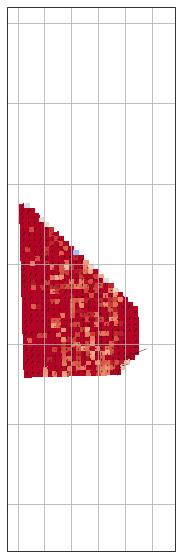

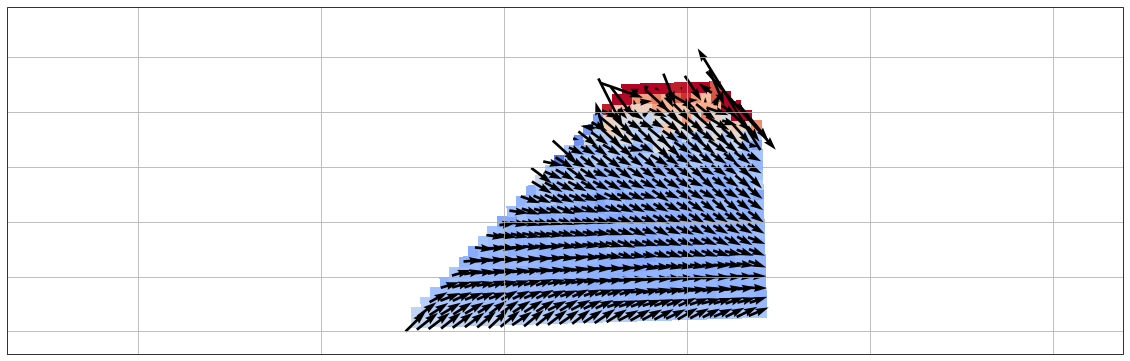

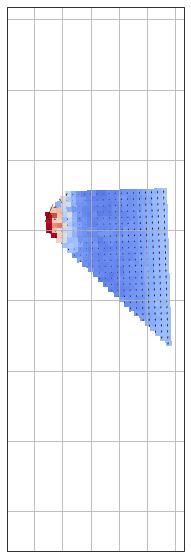

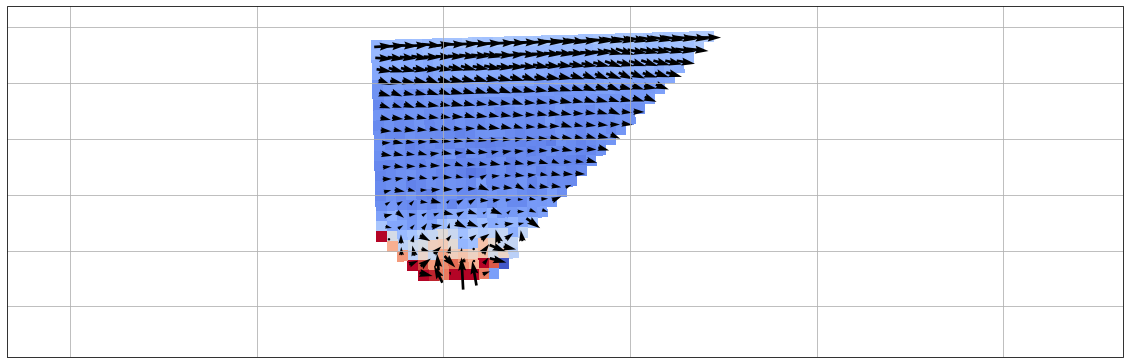

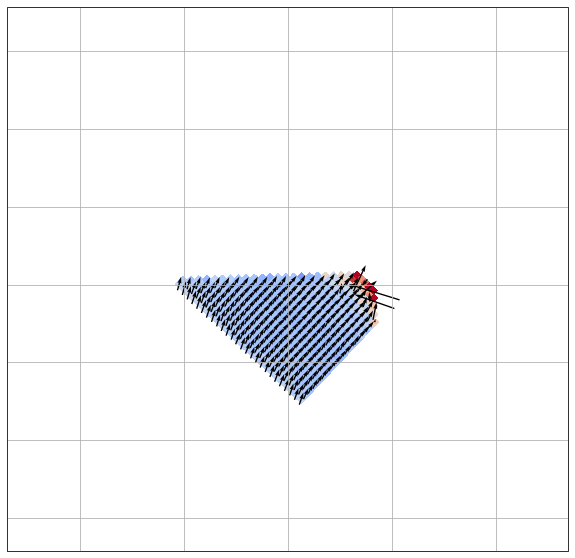

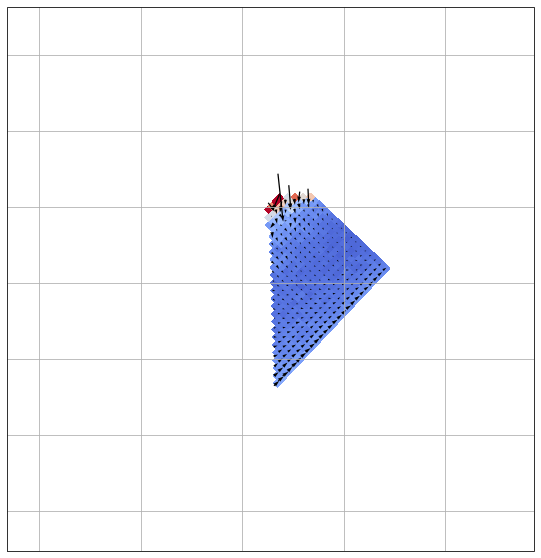

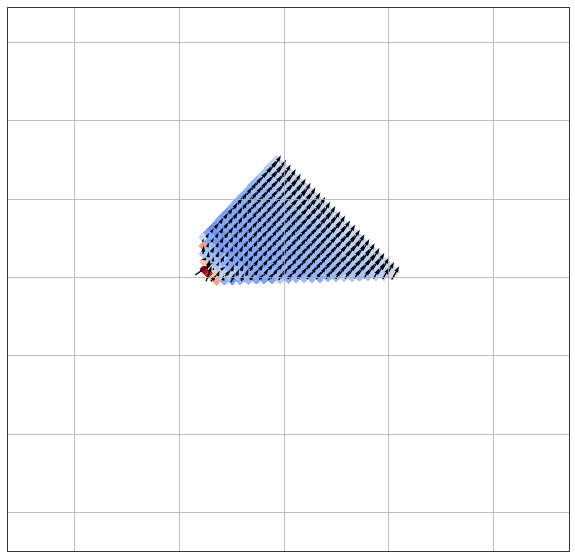

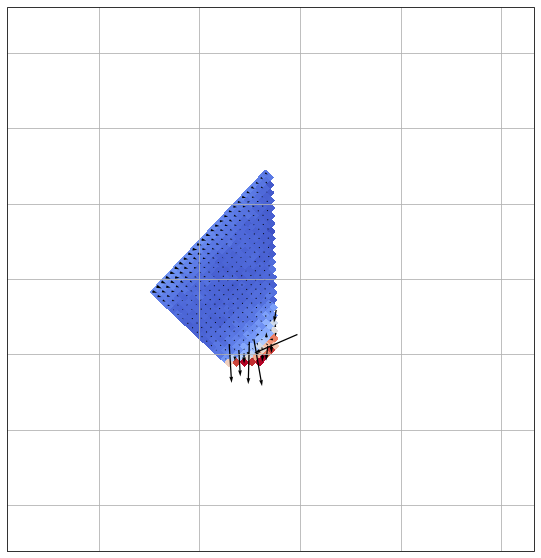

In [7]:
for track in ds_L2.keys():
    tracktime = str(np.datetime64(ds_L2[track].TrackTime.data,'m'))
    # Plot current magnitude with u,v vectors overlain, geographic coordinates
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor_image = int(plot_pixel_size / sar_pixel_size)
    #c_factor = 1 # Coarsening factor
    q_factor = 30 # Quiver plot scaling factor
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im=ds_L2[track]\
    .coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
    .coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
    .CurrentMagnitude.plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    ds_L2[track]\
    .coarsen(GroundRange=q_factor,boundary='trim').mean()\
    .coarsen(CrossRange=q_factor,boundary='trim').mean()\
    .plot.quiver(
        x='longitude',
        y='latitude',
        u='CurrentVectorUComponent',
        v='CurrentVectorVComponent',
        scale=50,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
    )
    
    #plt.title(ds_L1b[track].attrs['Title'])
    gl=ax.gridlines(draw_labels=False)
    gl.top_labels=False
    gl.right_labels=False
    
    gl.bottom_labels=False
    gl.left_labels=False
    
    #ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore", category=Warning)
    #ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    
    #cbar = plt.colorbar(im)
    #cbar.set_label('RSC velocity (m/s)',fontsize=30)
    
    #plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
    #plt.show()
    
    SMALL_SIZE = 20
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [ ]:
# Load Auxiliary data

#xband_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
#ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(xband_file, dsl2)
#ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(local_paths['xband_file'], dsl2)
#ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
#compute_Xband_current_magnitude_and_direction(ds_xband)

folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
[filename for filename in MARS2D_files if '0522' in filename]
aux_list=dict()
for data_type in ['MARS2D', 'MARS3D','HF_combined', 'WW3']:
    aux_list[data_type] =xr.open_dataset(
        file_paths['aux_path'] + folder
        + ''.join([f for f in aux_file_list if data_type in f and '0522' in f])
                                        )

cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['MARS2D'].U.data, aux_list['MARS2D'].V.data)
aux_list['MARS2D']['CurrentMagnitude'] = (('time','nj','ni'), cvel)
aux_list['MARS2D']['CurrentDirection'] = (('time','nj','ni'), cdir)


aux_list['HF_combined'] = aux_list['HF_combined'].assign_coords(
        coords={'longitude': aux_list['HF_combined'].longitude, 'latitude': aux_list['HF_combined'].latitude})
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['HF_combined'].U.data, aux_list['HF_combined'].V.data)
aux_list['HF_combined']['CurrentMagnitude'] = (('time','lat','lon'), cvel)
aux_list['HF_combined']['CurrentDirection'] = (('time','lat','lon'), cdir)

aux_list['HF_combined']['CurrentMagnitude'].assign_coords({'latitude':aux_list['HF_combined'].latitude,
                                                         'longitude':aux_list['HF_combined'].longitude})

aux_list['HF_radial'] = xr.open_dataset(file_paths['aux_path'] + folder
                            + 'HF_Brezellec_Radial_2022.nc')
aux_list['HF_radial'] = aux_list['HF_radial'].assign_coords({"latitude":(['lon', 'lat'], aux_list['HF_combined'].latitude.data),
                                     "longitude":(['lon', 'lat'], aux_list['HF_combined'].longitude.data)})
aux_list['HF_radial'] = aux_list['HF_radial'].drop_duplicates('time', keep='first')
#aux_list['HF_radial']['U'].assign_coords({'latitude':aux_list['HF_radial'].latitude,
#                                                         'longitude':aux_list['HF_radial'].longitude})
aux_list['Trefle_MLM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MLM.nc')
aux_list['Trefle_MEM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MEM.nc')
aux_list['Trefle_spectra'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_spectra.nc')
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))

In [ ]:
Trefle = xr.open_dataset(local_paths['aux_path'] + folder + 'Trefle_MLM.nc')
GL1 = xr.open_dataset(local_paths['aux_path'] + folder + 'GL_TS_MO_6200001.nc')

In [ ]:
for t in ds_comparison.time.data:
    HFCurrentMagnitude = aux_list['HF_combined'].CurrentMagnitude.sel(time=t, method='nearest')
    ds_comparison = xr.concat([ds_comparison, HFCurrentMagnitude], dim='time', join='outer')

In [ ]:
HFCurrentMagnitude

In [ ]:





aux_list['HF_combined'].CurrentMagnitude.interp(time=ds_L2[track].TrackTime,method='nearest')\
.plot(x='longitude',y='latitude')


In [ ]:
aux_list['HF_radial'].U.isel(time=0)\
.plot(x='longitude',y='latitude')

In [ ]:
latitude, longitude = np.meshgrid(aux_list['HF_combined'].latitude.data, aux_list['HF_combined'].longitude.data)
aux_list['HF_combined'].latitude

In [ ]:

aux_list['HF_radial'].isel(
    time=np.argmin(np.abs(aux_list['HF_radial'].time - ds_L2[track].TrackTime),keepdims=True).data
).U.plot(x='longitude',y='latitude')




In [ ]:
ds_comparison

In [ ]:
np.sqrt(aux_list['Trefle'].v_e.sel(time=ds_L2[track].TrackTime,method='nearest').isel(bin=0).data ** 2
 + aux_list['Trefle'].v_n.sel(time=ds_L2[track].TrackTime,method='nearest').isel(bin=0).data ** 2)

In [ ]:
aux_list['Trefle']

In [ ]:
def fill_missing_variables(ds_dict, antenna_id):

    fore_id = list(ds_dict.keys())[antenna_id.index('Fore')]
    mid_id = list(ds_dict.keys())[antenna_id.index('Mid')]
    aft_id = list(ds_dict.keys())[antenna_id.index('Aft')]
    # Find vars that dont exist in Mid , but exist in Fore
    for var in ds_dict[fore_id].data_vars:
        if var not in ds_dict[mid_id].data_vars:
            var_shape = (
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[0]]),
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[1]]))
            ds_dict[mid_id][var] = xr.DataArray(
                data=np.full(var_shape, np.NaN),
                coords=ds_dict[mid_id][var].coords,
                dims=ds_dict[mid_id][var].dims)
    # Find vars that dont exist in Fore for Aft , but exist in Mid
    for var in ds_dict[mid_id].data_vars:
        for antenna in [fore_id, aft_id]:
            if var not in ds_dict[antenna].data_vars:
                ds_dict[antenna][var] = xr.DataArray(
                    data=np.full(ds_dict[mid_id][var].shape, np.NaN),
                    coords=ds_dict[mid_id][var].coords,
                    dims=ds_dict[mid_id][var].dims)

    return ds_dict